In [ ]:
import torch
import torch.nn as nn
import numpy as np
import copy
import matplotlib.pyplot as plt

import torch_tmm
from torch_tmm import dispersion, Material, Model, Layer

from tmm_tests.test_dispersion import dispersion_sanity_test
from tmm_tests.test_material import material_sanity_check
from tmm_tests.test_layer import layer_sanity_check

In [2]:
dtype = torch.float64
device = torch.device('cpu')

wavelengths = torch.linspace(6000, 16000, 401)
angles = torch.linspace(45, 45, 1)

(0.0, 1.0)

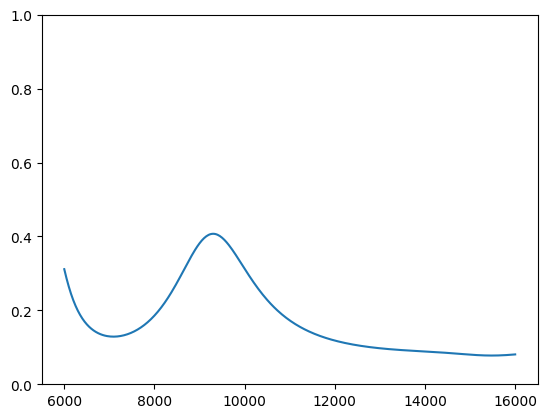

In [20]:
#Subs material
subs_mat = Material([dispersion.Constant_epsilon(14)], name='Silicon')
#Env material
env_mat = Material([dispersion.Constant_epsilon(1)], name='Air')
#Silicon layer material
aSi_mat = Material([dispersion.Lorentz(A = 0.002, 
                                                E0 = 0.08, 
                                                Gamma = 0.014),
                            dispersion.Constant_epsilon(12.0456)], name='aSi')
#Ti layer material
Ti_mat = Material([dispersion.Lorentz(A = 1.0416*80.92, 
                                               E0 = 0, 
                                               Gamma = 0.25)])
#Au layer material
Au_mat = Material([dispersion.Lorentz(A = 1.0092*10.06881, 
                                               E0 = 0, 
                                               Gamma = 0.15458)])

#Create layers
env = Layer(env_mat, layer_type='env')
subs = Layer(subs_mat, layer_type='subs')
Ti_layer = Layer(Ti_mat, layer_type='coh', thickness=2)
Au_layer = Layer(Au_mat, layer_type='coh', thickness=10)
aSi_layer = Layer(aSi_mat, layer_type='coh', thickness=2000)

#Thin-films face
optical_model = Model(env=env, structure=[aSi_layer, Au_layer, Ti_layer], subs=subs,
                                dtype=dtype, device=device)

#T = tranmission_with_backside(optical_model, wavelengths, angles)
calc = optical_model(wavelengths, angles)
T = calc.transmission('s')

plt.plot(wavelengths, T[:,0])
plt.ylim([0, 1])


Parameter containing:
tensor(2500., requires_grad=True)
0.022737160252771144
0.01873693034102965
0.01227495635323097
0.00516347241865453
0.001090784298928299
0.00012449509913877387
4.8103167871918084e-06
2.450789136619624e-08
2.637416652852995e-11
9.77185904059218e-12


(0.0, 1.0)

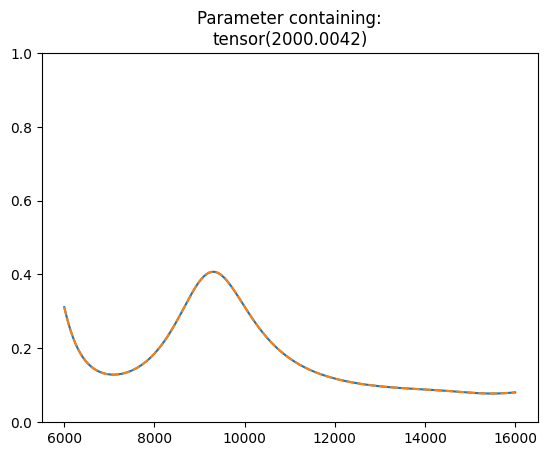

In [21]:
#Optimization test
optical_model.structure[0].thickness = torch.nn.Parameter(torch.tensor(2500.0))
optical_model.structure[0].thickness.requires_grad = True
print(optical_model.structure[0].thickness)

optimizer = torch.optim.Adam(optical_model.parameters(), lr=0.1)
criterion  = torch.nn.MSELoss()

num_iterations = 10000
for i in range(num_iterations):
    optimizer.zero_grad()  

    calc = optical_model(wavelengths, angles)
    T_probe = calc.transmission('s')
    loss = criterion(T_probe, T)
    loss.backward()
    optimizer.step()

    if i%1000 == 0:
        print(loss.detach().item())

angle = torch.where(angles == 45)
optical_model.structure[0].thickness.requires_grad = False

plt.title(optical_model.structure[0].thickness)
plt.plot(wavelengths, T[:,angle])
plt.plot(wavelengths, T_probe[:,angle].detach(), '--')
plt.ylim([0, 1])

Parameter containing:
tensor(0.0100, dtype=torch.float64, requires_grad=True)
loss:0.0017676033894734116
loss:2.4642697922484277e-12
loss:2.0212677360776167e-07


(0.0, 1.0)

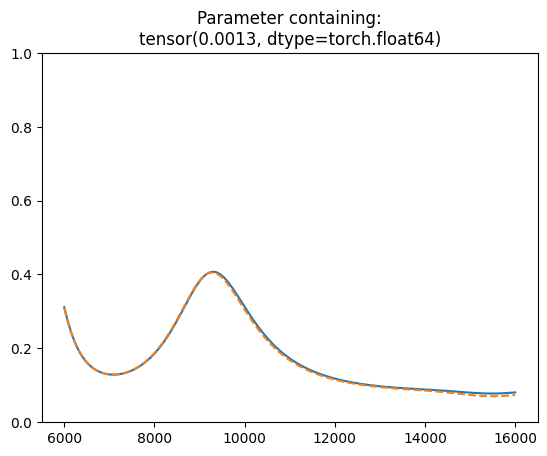

In [23]:
#Optimization test 2
optical_model.structure[0].material.dispersion[0].A = torch.nn.Parameter(torch.tensor(0.01, dtype=torch.float32))
optical_model.structure[0].material.dispersion[0].A.requires_grad = True
print(optical_model.structure[0].material.dispersion[0].A)

optimizer = torch.optim.Adam(optical_model.parameters(), lr=0.01)
criterion  = torch.nn.MSELoss()

num_iterations = 3000
for i in range(num_iterations):
    optimizer.zero_grad()  

    calc = optical_model(wavelengths, angles)
    T_probe = calc.transmission('s')
    loss = criterion(T_probe, T)
    loss.backward()
    optimizer.step()

    if i%1000 == 0:
        print(f'loss:{loss.detach().item()}')

angle = torch.where(angles == 45)
optical_model.structure[0].material.dispersion[0].A.requires_grad = False


plt.title(optical_model.structure[0].material.dispersion[0].A)
plt.plot(wavelengths, T[:,angle])
plt.plot(wavelengths, T_probe[:,angle].detach(), '--')
plt.ylim([0, 1])